In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
from albumentations.core.composition import BaseCompose
from tqdm import tqdm

from jumanji.config import ClassBox

In [2]:
# checkpoint_path = "/experiments/epoch=1.ckpt"
checkpoint_path = "/jumanji/efnetb0_torch15.pt"

In [3]:
model = torch.jit.load(checkpoint_path).eval().cuda()

In [4]:
def parse_transforms(tranforms_dict):
    transform_name = tranforms_dict["name"]
    transform_class = ClassBox.transforms[transform_name]
    if issubclass(transform_class, BaseCompose):
        params = tranforms_dict["params"]
        transforms = params.pop("transforms")
        transforms = [parse_transforms(transform) for transform in transforms]
        return transform_class(transforms=transforms, **params)
    else:
        return transform_class(**tranforms_dict.get("params", {}))

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import cv2

def plot_images(imgs, names=None):        
    fig, axs = plt.subplots(ncols=len(imgs), figsize=(16, 8))
    for i, ax in enumerate(axs):
        ax.imshow(imgs[i])
#         ax.set_axis_off()
        if names and i < len(names):
            ax.set_title(names[i], fontsize=15)
    plt.show()
    
def plot_image(img, img_size=5):
    img = np.array(img)

    height, width = img.shape[:2]
    fig = plt.figure()
    fig.set_size_inches(width / height * img_size, img_size, forward=True)
    ax = plt.Axes(fig, [0., 0., 1, 1])
#     ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(img, cmap=plt.get_cmap('gray'))

    plt.show()
    
def augment_and_show(aug, image, figsize=10, **kwargs):
    res = aug(image=image, **kwargs)
    image = res['image']
    if 'mask' in res:
        plot_images([image, res['mask']])
    else:
        plot_image(image, figsize)

In [6]:
import yaml
tranforms_dict = yaml.load(open("transforms.yml", "r"), Loader=yaml.FullLoader)
transform = parse_transforms(tranforms_dict)

In [7]:
test_dataset = ClassBox.datasets["ImageDataset"](csv_path="/data/projections/test.csv", 
                                            data_folder="/data/projections",
                                            augment=None,
                                            transform=transform
                                           )

In [8]:
y_pred = []
for (tensor, label) in tqdm(test_dataset):
    out = model(tensor.unsqueeze(0).cuda()).cpu()
    y_pred.append(out.item())

100%|██████████| 249/249 [00:11<00:00, 21.67it/s]


In [10]:
from sklearn.metrics import roc_curve, auc, plot_roc_curve

In [11]:
fpr, tpr, thresholds = roc_curve(test_dataset.csv.label, y_pred)

In [12]:
from matplotlib import pyplot as plt

In [13]:
from sklearn.metrics import f1_score

In [29]:
y = np.where(np.array(y_pred) > 0.82, 1, 0)

In [30]:
np.where(y != test_dataset.csv.label)

(array([], dtype=int64),)

In [31]:
f1_score(test_dataset.csv.label, y)

1.0

In [57]:
not_sure = np.where(abs(np.array(y_pred) - 0.5) < 0.4)[0]

0.39032477140426636


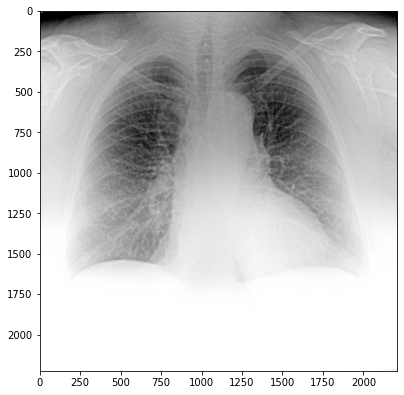

0.7956920862197876


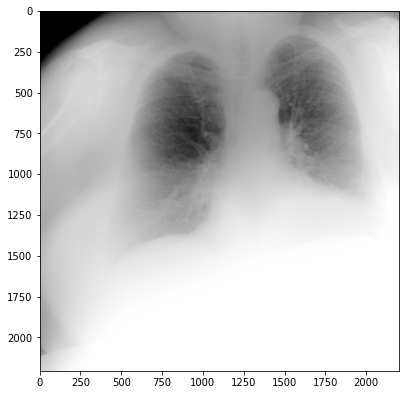

0.3577658236026764


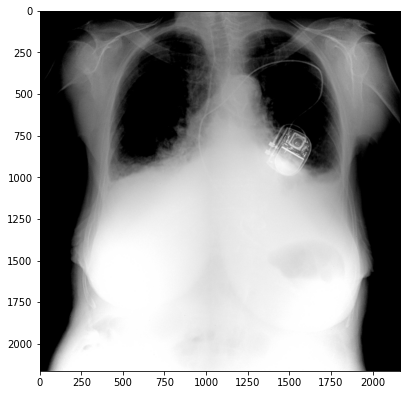

0.1616096943616867


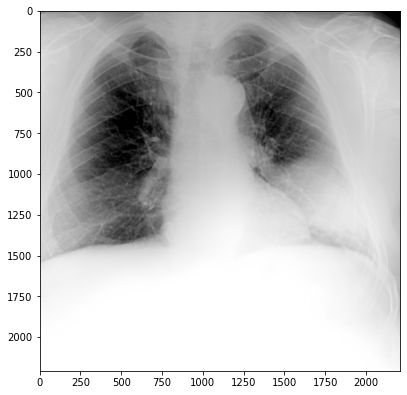

0.5485469698905945


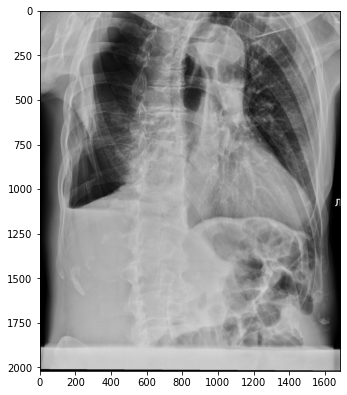

0.6606197953224182


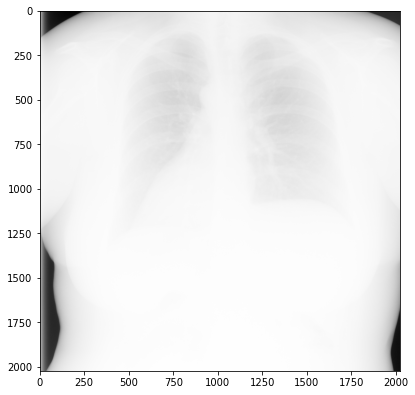

0.47674858570098877


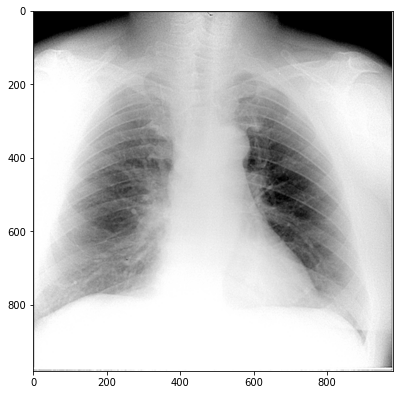

0.24522024393081665


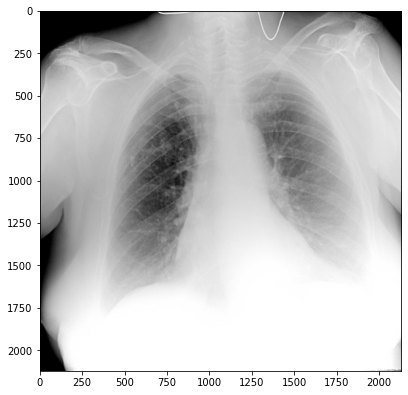

0.16581900417804718


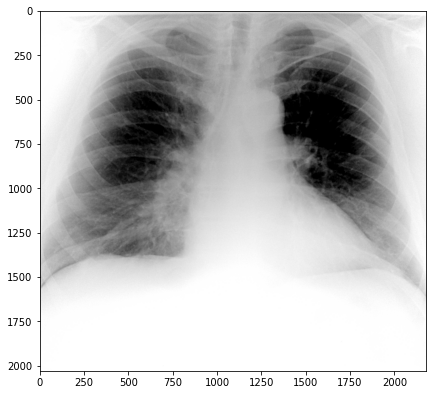

0.14996811747550964


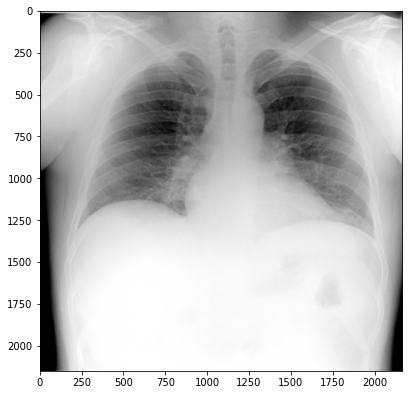

0.14937981963157654


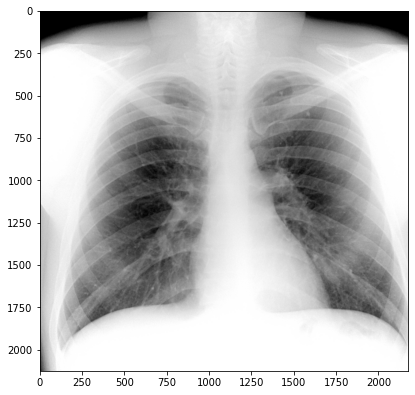

0.8080748319625854


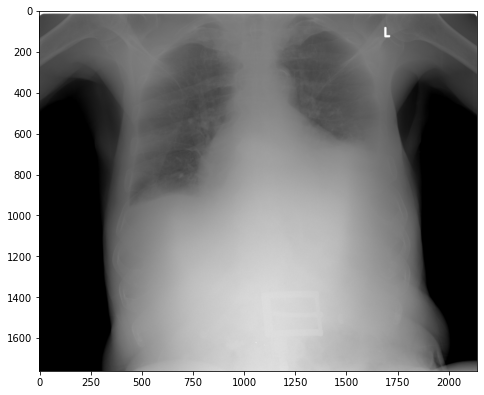

In [58]:
for iid in not_sure:
    print(y_pred[iid])
    plot_image(cv2.imread(str(test_dataset.csv.path[iid])))

In [32]:
valid_dataset = ClassBox.datasets["ImageDataset"](csv_path="/data/projections/valid.csv", 
                                            data_folder="/data/projections",
                                            augment=None,
                                            transform=transform
                                           )

In [33]:
y_pred = []
for (tensor, label) in tqdm(valid_dataset):
    out = model(tensor.unsqueeze(0).cuda()).cpu()
    y_pred.append(out.item())

100%|██████████| 3045/3045 [00:44<00:00, 68.72it/s]


In [34]:
fpr, tpr, thresholds = roc_curve(valid_dataset.csv.label, y_pred)

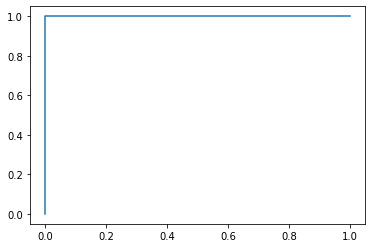

In [35]:
plt.plot(fpr, tpr)

In [46]:
y = np.where(np.array(y_pred) > 0.85, 1, 0)

In [47]:
np.where(y != valid_dataset.csv.label)

(array([], dtype=int64),)

In [65]:
not_sure = np.where(abs(np.array(y_pred) - 0.5) < 0.4)[0]

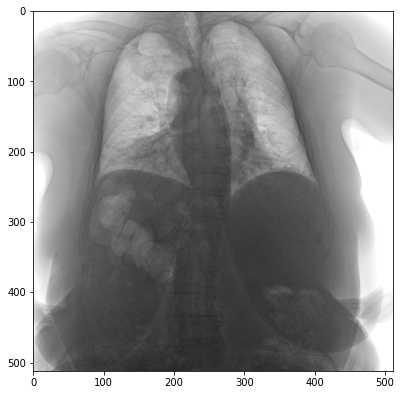

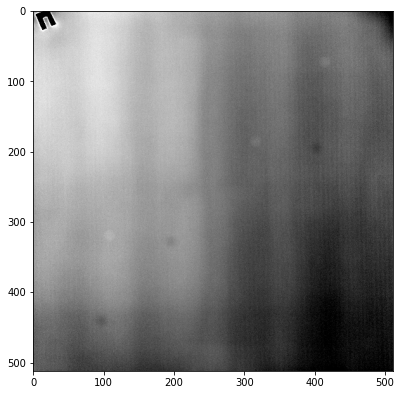

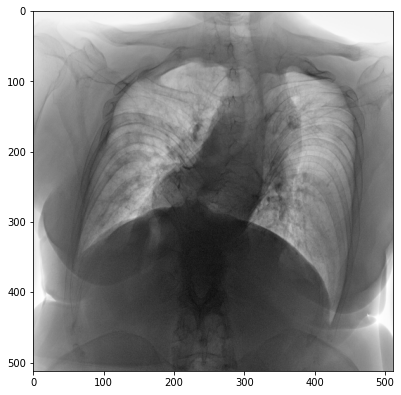

In [66]:
for iid in not_sure:
    plot_image(cv2.imread(str(valid_dataset.csv.path[iid])))

In [8]:
model = ClassBox.models["EfficientNetModel"](model_name="efficientnet-b0", in_channels=1, num_classes=1)

Loaded pretrained weights for efficientnet-b0


In [1]:
from model import TorchJitModel

In [2]:
model = TorchJitModel(checkpoint_path="../efnetb0_torch15.pt")

In [5]:
img = cv2.imread("/data/projections/input_249png/1.871.3.517682987.43744.17703.3477703325.103973453.1.1.1.png")

In [6]:
model.predict_batch([img, img])

array([0, 0], dtype=int32)

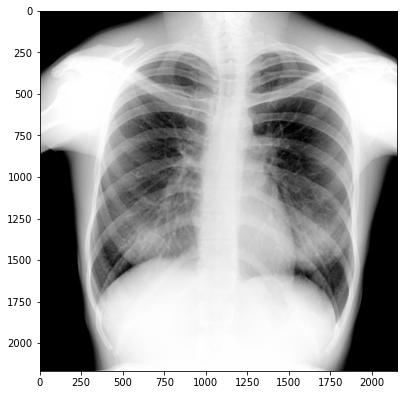

In [7]:
plot_image(img)

In [ ]:
[слово1 слово2 слово3 ... словоN]
[  1     0     1   ...   0 ]